In [1]:
%%capture
!pip install segmentation_models_pytorch
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
import optuna
import json
from PIL import Image, ImageDraw
import colorsys
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import albumentations as A
import torch.optim as optim
from pathlib import Path
import random
import copy
import logging
from tqdm import tqdm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data prepare
took from here: https://www.kaggle.com/code/dkudryavtsev/spacecraft-component-segmentation
* only add test data, 5 images to visualize them after train

In [2]:
class SpacecraftDataset(Dataset):
    def __init__(self, transforms, split='train'):
        """
        Initialize the dataset with the given transformations and data split.
        
        Args:
            transforms (callable): Transformations to be applied on the images and masks.
            split (str): Dataset split to use ('train', 'val', 'test'). Default is 'train'.
        """
        self.transforms = transforms
        
        if split == 'train':
            # Set the paths for training images and masks
            self.image_path = DATA / 'images/train'
            self.mask_path = DATA / 'mask/train'
            # Get sorted list of training image filenames
            self.image_filenames = sorted(self.image_path.glob('*.png'))
        else:
            # Set the paths for validation images and masks
            self.image_path = DATA / 'images/val'
            self.mask_path = DATA / 'mask/val'
            # Get sorted list of all validation image filenames
            all_image_filenames = sorted(self.image_path.glob('*.png'))
            
            if split == 'val':
                # For validation split, exclude test filenames
                self.image_filenames = [f for f in all_image_filenames if f not in self.test_filenames]
            elif split == 'test':
                # For test split, randomly select 5 images
                self.image_filenames = random.sample(all_image_filenames, 5)
        
    def __len__(self):
        """
        Return the total number of images in the dataset.
        """
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        """
        Retrieve the image and mask pair at the specified index.
        
        Args:
            idx (int): Index of the image and mask to retrieve.
            
        Returns:
            tuple: Transformed image and mask tensors.
        """
        try:
            # Get the image filename at the given index
            image_filename = self.image_filenames[idx]
            # Read the image and convert it to RGB
            image = cv2.imread(str(image_filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   
            # Get the corresponding mask filename
            mask_filename = self.mask_path / (image_filename.stem + '_mask.png')
            if mask_filename.is_file():
                # Read the mask in grayscale
                mask = cv2.imread(str(mask_filename), cv2.IMREAD_GRAYSCALE)
            else:
                raise IOError  # Raise an error if mask file does not exist
            
            # Adjust mask for 1 class + background
            mask[mask != 0] = 1  # Foreground class
            # Add channel dimension to the mask
            mask = np.expand_dims(mask, axis=-1).astype(np.float32)
                                    
            # Apply transformations to the image and mask
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            # Change mask shape from (H, W, C) to (C, H, W)
            mask = mask.permute(2, 0, 1)
            
            return image, mask.to(torch.float32)
            
        except:
            if idx + 1 < len(self):
                # If an error occurs, try the next index
                return self.__getitem__(idx + 1)
            else:
                # If no more images are available, raise StopIteration
                raise StopIteration

# Define DATA path
DATA = Path('/kaggle/input/spacecrafts/Spacecrafts')

# Ensure random seed for reproducibility
random.seed(42)

# List of all image filenames in validation directory
all_image_filenames = sorted((DATA / 'images/val').glob('*.png'))

# Randomly select 5 images for the test split
SpacecraftDataset.test_filenames = random.sample(all_image_filenames, 5)


## Transformations

In [3]:
train_aug = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomCropFromBorders(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
        A.AdvancedBlur(),
        A.RandomBrightnessContrast(brightness_limit=[-0.3, 0.1])
    ]),
    A.Resize(544, 544),
    A.RandomRotate90(),
    A.Normalize(),
    ToTensorV2()
    ])

aug = A.Compose([
    A.Resize(544, 544),
    A.Normalize(),
    ToTensorV2()
])

In [4]:
train_dataset = SpacecraftDataset(transforms=train_aug)
val_dataset = SpacecraftDataset(transforms=aug, split='val')
test_dataset = SpacecraftDataset(transforms=aug, split='test')

## Data visualization

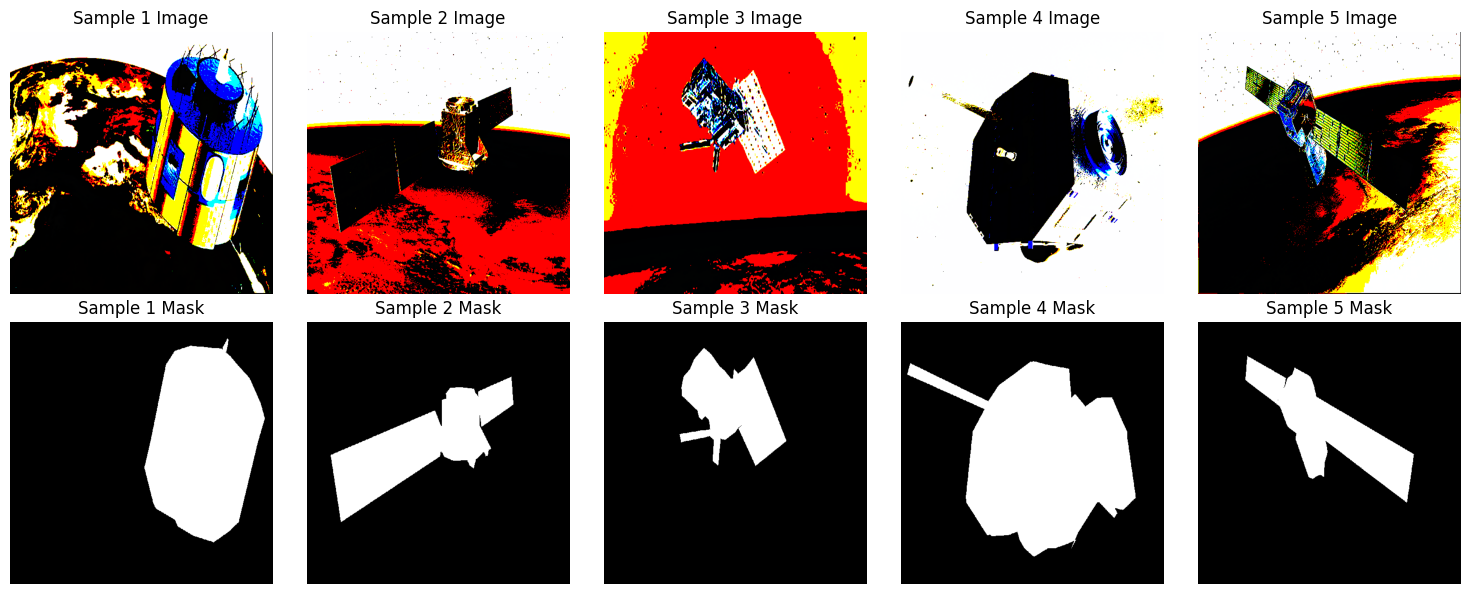

In [5]:
def visualize_samples(dataset, num_samples=5):
    """
    Visualize a specified number of image and mask pairs from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize samples from.
        num_samples (int): The number of samples to visualize. Default is 5.
    """
    # Ensure the number of samples doesn't exceed the length of the dataset
    num_samples = min(num_samples, len(dataset))
    
    # Set up the matplotlib figure with one row and num_samples columns
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get the image and mask pair
        image, mask = dataset[i]
        
        # Convert the image and mask to numpy arrays for visualization
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
        mask = mask.squeeze().numpy()
        
        # Display the image
        axes[0, i].imshow(image)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Sample {i+1} Image')
        
        # Display the mask
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Sample {i+1} Mask')
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()


visualize_samples(val_dataset, num_samples=5)

## Model train
* PyLightning was not working, so I write my own Class for hyperparameter serach, model train, test data visualize

In [6]:
class SegmentationPipeline:
    def __init__(self, train_dataset, val_dataset, test_dataset, models, encoders, lr_range, epochs, batch_size):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.models = models
        self.encoders = encoders
        self.lr_range = lr_range
        self.epochs = epochs
        self.batch_size = batch_size
        self.best_params = None
        self.freeze_encoder_until_epoch = 10
        self.criterion = nn.BCEWithLogitsLoss()

    def IoU(self, preds, targs, eps: float = 1e-8):
        # Ensure preds and targs have the same number of dimensions
        if preds.dim() != targs.dim():
            raise ValueError("Prediction and target tensors must have the same number of dimensions")

        # Check and add channel dimension if missing
        if preds.shape[1] != 1:
            preds = preds.unsqueeze(1)
        if targs.shape[1] != 1:
            targs = targs.unsqueeze(1)
        
        preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
        preds = (preds > 0.5).float()  # Threshold to get binary predictions
             
        intersection = (preds * targs).sum(dim=(1, 2, 3))
        union = (preds + targs).sum(dim=(1, 2, 3)) - intersection
        iou = (intersection / (union + eps)).mean()

        return iou

    class SegModel(nn.Module):
        def __init__(self, arch, encoder_name, encoder_weights):
            super().__init__()
            self.net = smp.create_model(arch,
                                        encoder_name=encoder_name,
                                        encoder_weights=encoder_weights,
                                        in_channels=3,
                                        classes=1)

        def forward(self, x):
            return self.net(x)

    def on_epoch_end(self, model, current_epoch):
        if current_epoch >= self.freeze_encoder_until_epoch:
            for param in model.net.encoder.parameters():
                param.requires_grad = True

    def configure_optimizers(self, model, lr):
        opt = optim.Adamax(model.parameters(), lr=lr)
        sch = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10)
        return opt, sch

    def train_model(self, model, criterion, optimizer, scheduler, dataloaders, device, num_epochs, model_save_path='best_model.pth', grad_accum_steps=1):
        best_iou = 0.0
        best_model_wts = copy.deepcopy(model.state_dict())

        for epoch in range(num_epochs):
            logging.info(f'Epoch {epoch}/{num_epochs - 1}')
            logging.info('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_iou = 0.0
                num_samples = 0

                with tqdm(total=len(dataloaders[phase]),
                          desc=f"{phase} Epoch {epoch + 1}/{num_epochs}",
                          unit="batch", leave=False) as pbar:
                    for i, (inputs, labels) in enumerate(dataloaders[phase]):
                        if inputs.size(0) == 1:
                            continue
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        optimizer.zero_grad()

                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            iou = self.IoU(outputs, labels)

                            if phase == 'train':
                                loss.backward()
                                if (i + 1) % grad_accum_steps == 0:
                                    optimizer.step()
                                    optimizer.zero_grad()

                        running_loss += loss.item() * inputs.size(0)
                        running_iou += iou.item() * inputs.size(0)
                        num_samples += inputs.size(0)

                        pbar.set_postfix({"IoU": f"{running_iou / num_samples:.4f}"})
                        pbar.update(1)
                        pbar.update(1)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / num_samples
                epoch_iou = running_iou / num_samples

                logging.info(f'{phase} Loss: {epoch_loss:.4f} IoU: {epoch_iou:.4f}')

                if phase == 'val' and epoch_iou > best_iou:
                    best_iou = epoch_iou
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), model_save_path)

            self.on_epoch_end(model, epoch)
            logging.info('')

        logging.info(f'Best val IoU: {best_iou:.4f}')
        model.load_state_dict(best_model_wts)
        return best_iou

    def objective(self, trial):
        model_type = trial.suggest_categorical("model_type", self.models)
        encoder_type = trial.suggest_categorical("encoder_type", self.encoders)
        lr = trial.suggest_loguniform("lr", self.lr_range[0], self.lr_range[1])
        pretrained = trial.suggest_categorical("pretrained", [True, False])

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = self.SegModel(model_type, encoder_type, "imagenet" if pretrained else None).to(device)
        criterion = self.criterion
        optimizer, scheduler = self.configure_optimizers(model, lr)

        dataloaders = {
            'train': DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True if torch.cuda.is_available() else False),
            'val': DataLoader(self.val_dataset, batch_size=self.batch_size, pin_memory=True if torch.cuda.is_available() else False)
        }

        best_iou = self.train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=5, grad_accum_steps=2)
        return best_iou

    def save_best_params(self, filepath):
        with open(filepath, 'w') as f:
            json.dump(self.best_params, f)

    def load_best_params(self, filepath):
        with open(filepath, 'r') as f:
            self.best_params = json.load(f)

    def run_hyperparameter_search(self, n_trials=100, timeout=12000):
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="maximize")
        study.optimize(self.objective, n_trials=n_trials, timeout=timeout)

        self.best_params = study.best_trial.params
        logging.info("Best trial:")
        logging.info(f"  Value: {study.best_trial.value}")
        logging.info("  Params: ")
        for key, value in study.best_trial.params.items():
            logging.info(f"    {key}: {value}")

    def set_best_params(self, best_params):
        self.best_params = best_params

    def train_with_best_params(self, num_epochs=None):
        if self.best_params is None:
            raise ValueError("Hyperparameters not found. Run hyperparameter search first or set them using set_best_params.")

        model_type = self.best_params["model_type"]
        encoder_type = self.best_params["encoder_type"]
        lr = self.best_params["lr"]
        pretrained = self.best_params.get("pretrained", True)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = self.SegModel(model_type, encoder_type, "imagenet" if pretrained else None).to(device)
        criterion = self.criterion
        optimizer, scheduler = self.configure_optimizers(model, lr)

        dataloaders = {
            'train': DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True if torch.cuda.is_available() else False, num_workers=os.cpu_count()),
            'val': DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True if torch.cuda.is_available() else False, num_workers=os.cpu_count()),
            'test': DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True if torch.cuda.is_available() else False, num_workers=os.cpu_count())
        }

        best_iou = self.train_model(model, criterion, optimizer,
                                    scheduler, dataloaders, device, num_epochs or self.epochs, grad_accum_steps=2)

        model.eval()
        test_iou = 0.0
        test_loss = 0.0
        num_samples = 0

        with tqdm(total=len(dataloaders['test']), desc="Testing", unit="batch", leave=False) as pbar:
            for inputs, labels in dataloaders['test']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    outputs = outputs.squeeze(1)
                    labels = labels.squeeze(1)
                    loss = criterion(outputs, labels)
                    iou = self.IoU(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                test_iou += iou.item() * inputs.size(0)
                num_samples += inputs.size(0)
                pbar.update(1)

        test_loss = test_loss / num_samples
        test_iou = test_iou / num_samples

        logging.info(f'Test Loss: {test_loss:.4f} Test IoU: {test_iou:.4f}')
        return test_iou

    def visualize_test_sample(self, model_path, num_samples):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = self.SegModel(self.best_params["model_type"], self.best_params["encoder_type"], "imagenet" if self.best_params.get("pretrained", True) else None).to(device)
        model.load_state_dict(torch.load(model_path))

        model.eval()

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

        for i in range(num_samples):
            sample = self.test_dataset[i]
            img = sample[0].unsqueeze(0).to(device)
            mask = sample[1].to(device)

            with torch.no_grad():
                pred = model(img)

            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()

            img = img.cpu().squeeze().permute(1, 2, 0).numpy()
            mask = mask.cpu().numpy().squeeze()
            pred = pred.cpu().numpy().squeeze()

            if num_samples == 1:
                axes[0].imshow(img)
                axes[0].set_title("Original Image")
                axes[0].axis("off")

                axes[1].imshow(mask, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")

                axes[2].imshow(pred, cmap="gray")
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")
            else:
                axes[i, 0].imshow(img)
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis("off")

                axes[i, 1].imshow(mask, cmap="gray")
                axes[i, 1].set_title("Ground Truth Mask")
                axes[i, 1].axis("off")

                axes[i, 2].imshow(pred, cmap="gray")
                axes[i, 2].set_title("Predicted Mask")
                axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()

In [7]:
pipeline = SegmentationPipeline(
    train_dataset=train_dataset, 
    val_dataset=val_dataset, 
    test_dataset=test_dataset, 
    models=['FPN', 'Unet', 'DeepLabV3'], 
    encoders=['resnet150', 'timm-mobilenetv3_large_100', 'timm-efficientnet-b3'], 
    lr_range=(1e-6, 1e-2), 
    epochs=5, 
    batch_size=4
)

# Set the best parameters including pretrained flag
best_params = {
    "model_type": "DeepLabV3",
    "encoder_type": "timm-mobilenetv3_large_100",
    "lr": 0.00001,
    "pretrained": True
}
pipeline.set_best_params(best_params)

# Train with the externally set best parameters and evaluate on the test set
pipeline.train_with_best_params(num_epochs=50)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 186MB/s]


0.7312684655189514

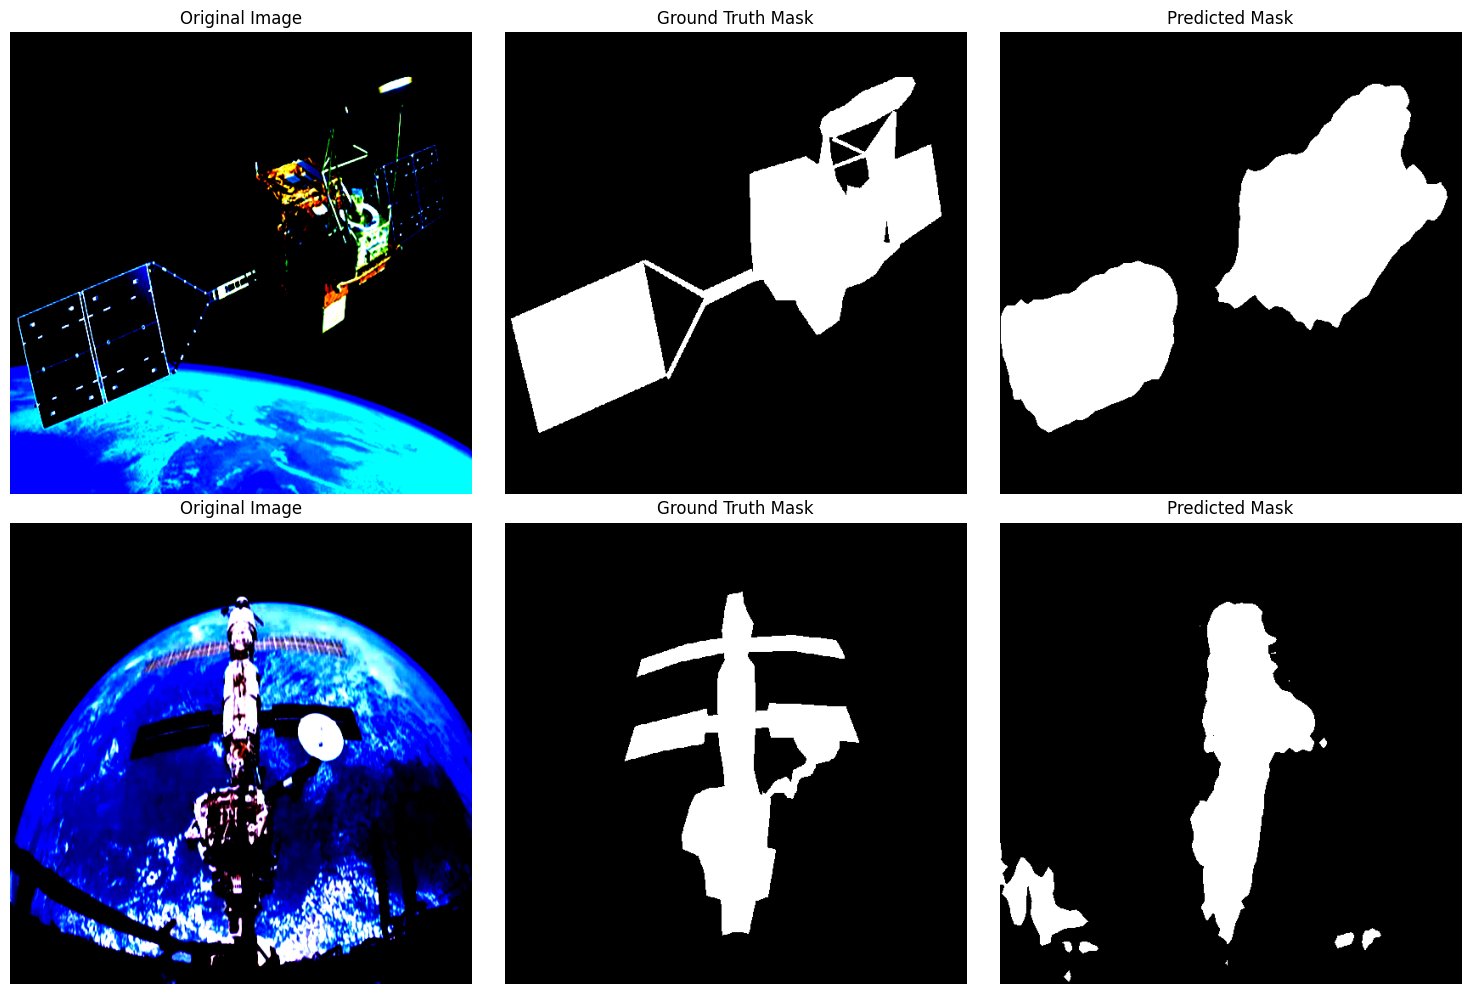

In [8]:
pipeline.visualize_test_sample('/kaggle/working/best_model.pth', 2)

# Conclusion
* Libraries are not almighty, sometimes easier write your own than try to find how to fix bug
* Need to add oportunity to use multiple gpus in my class, I could not make hyp search cause of out of memory
* Results looks good enough even on IoU:0.73